In [1]:
import sys, itertools, re, sqlite3, math, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Normalization
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display, Markdown
from PIL import Image

In [2]:
rcParams["figure.figsize"] = (18,8)
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
current_path = os.getcwd()
sys.path.append(current_path)

# enable to get always the same result model
tf.keras.utils.set_random_seed(1)
tf.random.set_seed(1)
#tf.config.experimental.enable_op_determinism()

NUM_OF_CATEGORIES = 4
EPOCHS = 3000

feature_column = "k_rechtsvorm,k_sbi1,k_sbi2,k_sbi3,j_account,j_subcat,j_bedrag,c_investeringsverw,c_beursontwikkeling,m_M,m_UM,m_TA,r_bestaan,r_voorkomen,r_volledigheid,r_nauwkeurigheid,r_waardering,r_afgrenzing,r_classificatie,r_presentatie,r_rechten_en_verplichtingen"
feature_names = feature_column.split(',')
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []
y_test = []
conn = sqlite3.connect(os.path.join(current_path,"tmp","save.db3"))
curr = conn.cursor()
curr.execute(f"Select {feature_column},result,set_type FROM DataSet")
label_size_cor = None
for row in curr.fetchall():
    label_size_cor = (len(feature_names),len(row)-2)
    if row[-1] == "training":
        X_train.append(row[:-2])
        y_train.append(row[-2])
    if row[-1] == "valid":
        X_valid.append(row[:-2])
        y_valid.append(row[-2])
    if row[-1] == "test":
        X_test.append(row[:-2])
        y_test.append(row[-2])
conn.close()
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

from keras import utils
y_nosparse_train = utils.to_categorical(y_train, NUM_OF_CATEGORIES)
y_nosparse_valid = utils.to_categorical(y_valid, NUM_OF_CATEGORIES)
y_nosparse_test = utils.to_categorical(y_test, NUM_OF_CATEGORIES)

(10572, 21) (10572,)
(1760, 21) (1760,)
(1764, 21) (1764,)


In [3]:
from dbn.dbn.tensorflow import SupervisedDBNClassification
model = SupervisedDBNClassification(hidden_layers_structure=[256, 256],
                                         learning_rate_rbm=0.05,
                                         learning_rate=0.5,
                                         n_epochs_rbm=10,
                                         n_iter_backprop=EPOCHS,
                                         batch_size=64,
                                         activation_function='relu',
                                         dropout_p=0.1)

history = model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score
m, e, h = model, [hamming_loss(y_test, Y_pred), accuracy_score(y_test, Y_pred), precision_score(y_test, Y_pred, average='micro'), recall_score(y_test, Y_pred, average='micro')], history

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.915707
>> Epoch 2 finished 	RBM Reconstruction error 0.891889
>> Epoch 3 finished 	RBM Reconstruction error 0.838549
>> Epoch 4 finished 	RBM Reconstruction error 0.802529
>> Epoch 5 finished 	RBM Reconstruction error 0.792035
>> Epoch 6 finished 	RBM Reconstruction error 0.799653
>> Epoch 7 finished 	RBM Reconstruction error 0.847493
>> Epoch 8 finished 	RBM Reconstruction error 0.900758
>> Epoch 9 finished 	RBM Reconstruction error 0.999769
>> Epoch 10 finished 	RBM Reconstruction error 1.179654
>> Epoch 1 finished 	RBM Reconstruction error 200.691254
>> Epoch 2 finished 	RBM Reconstruction error 306.441498
>> Epoch 3 finished 	RBM Reconstruction error 248.558105
>> Epoch 4 finished 	RBM Reconstruction error 295.272522
>> Epoch 5 finished 	RBM Reconstruction error 300.310516
>> Epoch 6 finished 	RBM Reconstruction error 367.513885
>> Epoch 7 finished 	RBM Reconstruction error 245.103653
>> Epoch 8 finished 	RB

<h2>Deep Belief Networks (DBN)</h2>

Loss: 0.16
Accuracy: 84%
Precision: 0.84
Recall: 0.84


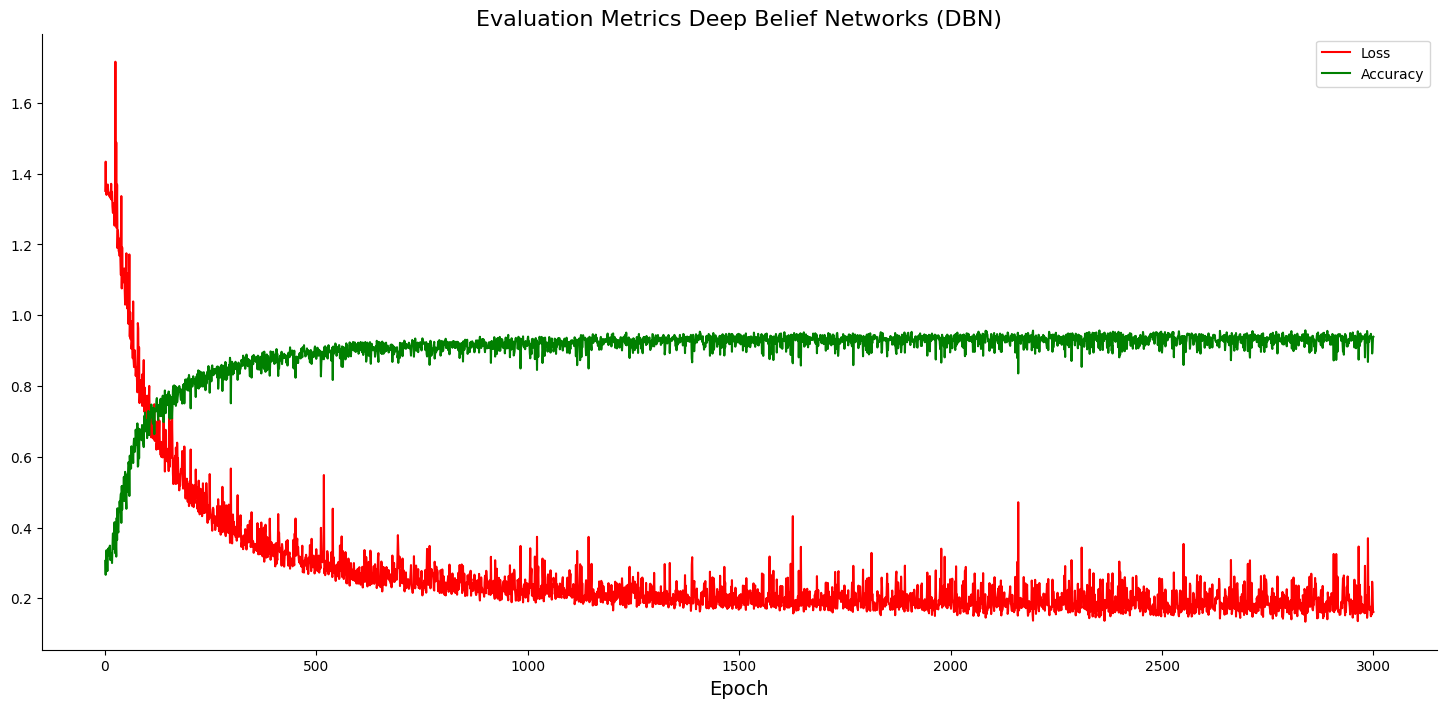

In [4]:
name = "Deep Belief Networks (DBN)"
display(Markdown(f'<h2>{name}</h2>'))
print(f'Loss: {e[0]:.2f}')
print(f'Accuracy: {int(e[1] * 100)}%')
print(f'Precision: {e[2]:.2f}')
print(f'Recall: {e[3]:.2f}')

plt.figure(1)
range_epochs = np.arange(1, len(h.losses)+1)
plt.plot(range_epochs, h.losses, label='Loss',color='red')
plt.plot(range_epochs, h.accuracies, label='Accuracy',color='green')
plt.title(f"Evaluation Metrics {name}", size=16)
plt.xlabel("Epoch", size=14)
plt.legend()
plt.show()

In [7]:
test_set = []
res_set = []

con2 = sqlite3.connect(os.path.join(current_path,"tmp","save.db3"))
cur2 = con2.cursor()
cur2.execute(f"Select {feature_column},result FROM DataSet")
rows = cur2.fetchall()
parameters = [[float(item or 0) for item in row[:-1]] for row in rows]
expected = [int(row[-1]) for row in rows]
con2.close()

print("Outcome diversity: ", expected.count(0),expected.count(1),expected.count(2),expected.count(3))

test_valid = np.array(parameters)
predicted = list(model.predict(test_valid))
check = []
for idx, res in enumerate(expected):
    check.append(predicted[idx]==res)
print("Number of wrong:", check.count(False), "out of", len(check))

Outcome diversity:  3524 3524 3524 3524
Number of wrong: 1188 out of 14096
